<a href="https://colab.research.google.com/github/youngclick/advGIS/blob/master/samplingPoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import ee
import geemap

In [19]:
ee.Authenticate()
ee.Initialize(project='ee-youngclick')

In [20]:
# Manually define the path for the uploaded ZIP file
zip_file_path = '/content/shelbyFarmBoundary.zip'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/shelby_farm_park')


In [21]:
# Unzip the uploaded file
import zipfile
import os

# Define the path for the uploaded ZIP file
#zip_file_path = list(uploaded.keys())[0]

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/shelby_farm_park')

# Read the shapefile using GeoPandas
import geopandas as gpd

# Replace 'your_shapefile.shp' with the actual name of your .shp file within the extracted folder
shapefile_path = '/content/shelby_farm_park/shelby.shp'
park_gdf = gpd.read_file(shapefile_path)

# Display the GeoDataFrame to confirm
print(park_gdf)


   OBJECTID                 PERMANENT_          NAME  PARKING_AR PARKING_SU  \
0     218.0  CPGIS47157031120131243232  Shelby Farms   718859.17      Paved   

      Shape_Leng    Shape_Area  \
0  107524.563123  1.883421e+08   

                                            geometry  
0  MULTIPOLYGON (((817494.938 314446.625, 817497....  


In [22]:
# Convert the GeoDataFrame geometry to a GeoJSON format
import geemap

# Convert GeoDataFrame to Earth Engine geometry
park_ee_geometry = geemap.geopandas_to_ee(park_gdf)

# Initialize Earth Engine (assuming you've already authenticated earlier)
import ee
ee.Initialize()

# Visualize the study area on a map
Map = geemap.Map()
Map.centerObject(park_ee_geometry, 14)
Map.addLayer(park_ee_geometry, {'color': 'blue'}, 'Shelby Farms Park')
Map


Map(center=[35.13641456759685, -89.83340859745], controls=(WidgetControl(options=['position', 'transparent_bg'…

In [36]:
# Load Sentinel-2 imagery, filter by date and cloud cover
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR') \
            .filterDate('2023-01-01', '2023-12-31') \
            .filterBounds(park_ee_geometry) \
            .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10) \
            .median()  # Median composite to reduce noise

# Calculate NDVI using the Near-Infrared (B8) and Red (B4) bands
ndvi = sentinel2.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Visualize NDVI on the map
ndvi_params = {'min': 0, 'max': 1, 'palette': ['white', 'green']}
Map.addLayer(ndvi.clip(park_ee_geometry), ndvi_params, 'NDVI')
Map


Map(bottom=829961.0, center=[35.14279225107212, -89.83237266540529], controls=(WidgetControl(options=['positio…

In [23]:
# Define a threshold for classifying forest vs. non-forest
forest_threshold = 0.4

# Create a binary classification image: 1 for forest, 0 for non-forest
forest_class = ndvi.gt(forest_threshold).rename('Forest_Class')


In [35]:
# Define visualization parameters for the classification
forest_params = {'min': 0, 'max': 1, 'palette': ['yellow', 'darkgreen']}

# Add the forest classification layer to the map
Map.addLayer(forest_class.clip(park_ee_geometry), forest_params, 'Forest Classification')
Map

Map(bottom=829962.0, center=[35.14265188000348, -89.83254432678223], controls=(WidgetControl(options=['positio…

In [37]:
# Calculate the pixel area (in square meters) for each pixel classified as forest
forest_area_image = forest_class.multiply(ee.Image.pixelArea())

# Sum up all the forest pixel areas within the study region
forest_area = forest_area_image.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=park_ee_geometry,
    scale=10,  # Scale of Sentinel-2 imagery in meters
    maxPixels=1e9
)

# Get the total forest area in square meters
total_forest_area_sq_m = forest_area.getInfo().get('Forest_Class')

# Convert the total forest area from square meters to hectares (1 hectare = 10,000 square meters)
total_forest_area_hectares = total_forest_area_sq_m / 10000

# Print the result
print(f"Total Forest Area: {total_forest_area_hectares:.2f} hectares")


Total Forest Area: 834.87 hectares


In [29]:
# Install rasterio
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 46.7 MB/s eta 0:00:00


In [38]:
# Convert the forest classification image to a vector polygon
forest_vector = forest_class.updateMask(forest_class).reduceToVectors(
    geometryType='polygon',
    reducer=ee.Reducer.countEvery(),
    scale=10,  # Use the resolution of Sentinel-2
    geometry=park_ee_geometry,
    maxPixels=1e9
)

# Simplify the vector polygons for efficient processing
forest_polygon = forest_vector.geometry()


In [43]:
import geopandas as gpd
from shapely.geometry import shape

# Convert the Earth Engine polygon to a GeoJSON dictionary
forest_geojson = forest_polygon.getInfo()  # Get the GeoJSON information as a dictionary

# Extract the features from the GeoJSON dictionary
forest_features = [shape(forest_geojson)]

# Create a GeoDataFrame from the features
forest_gdf = gpd.GeoDataFrame(geometry=forest_features, crs="EPSG:4326")

# Now proceed to generate random plots within the forest GeoDataFrame


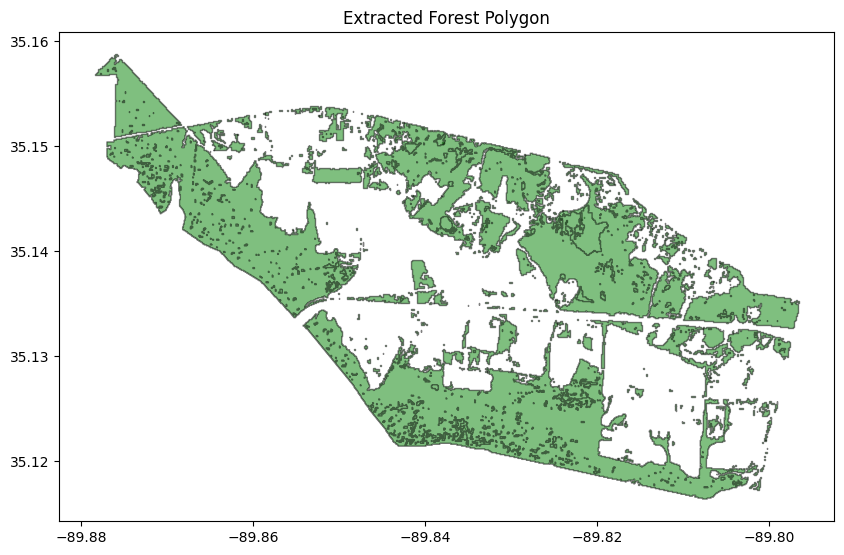

In [45]:
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt

# Convert the Earth Engine polygon to a GeoJSON dictionary
forest_geojson = forest_polygon.getInfo()  # Get the GeoJSON information as a dictionary

# Extract the features from the GeoJSON dictionary
forest_features = [shape(forest_geojson)]

# Create a GeoDataFrame from the features
forest_gdf = gpd.GeoDataFrame(geometry=forest_features, crs="EPSG:4326")

# Plot the forest GeoDataFrame to inspect the output
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
forest_gdf.plot(ax=ax, color='green', edgecolor='black', alpha=0.5)
plt.title("Extracted Forest Polygon")
plt.show()


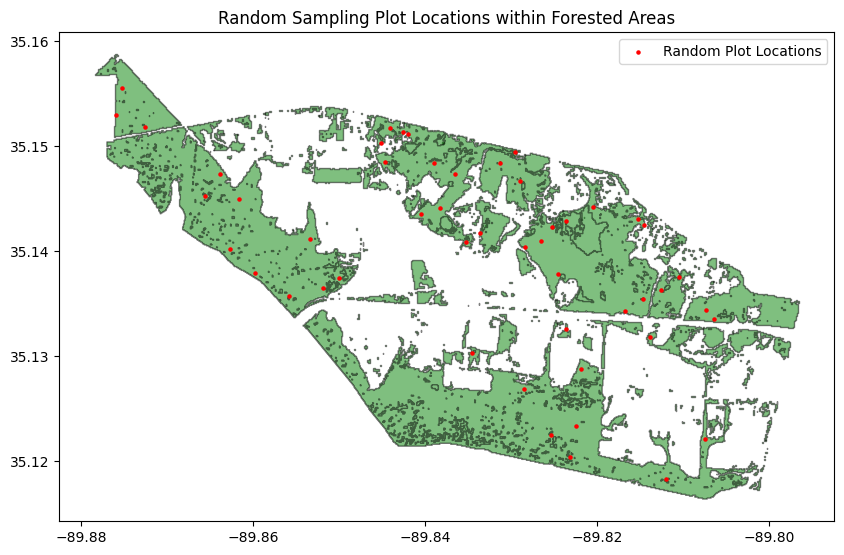

In [46]:
import random
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

# Define a function to generate random points within a polygon
def generate_random_points_within_polygon(geometry, num_points, plot_radius):
    minx, miny, maxx, maxy = geometry.bounds
    plot_points = []

    while len(plot_points) < num_points:
        # Generate a random point within the bounding box
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        # Check if the point is within the forest polygon
        if geometry.contains(pnt):
            plot_points.append(pnt)

    # Create GeoDataFrame of plot points
    plots_gdf = gpd.GeoDataFrame({'geometry': plot_points}, crs="EPSG:4326")
    return plots_gdf

# Number of random plots and plot radius (1/6 acre ~ 14.66 m radius)
num_random_plots = 50
plot_radius = 14.66  # Not directly used here, but good for documentation

# Generate random points within the forest polygons
random_forest_plots_gdf = generate_random_points_within_polygon(forest_gdf.unary_union, num_random_plots, plot_radius)

# Plot the forest polygons and random plots on a map to visualize the result
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
forest_gdf.plot(ax=ax, color='green', edgecolor='black', alpha=0.5, label='Forest Area')
random_forest_plots_gdf.plot(ax=ax, color='red', markersize=5, label='Random Plot Locations')
plt.title("Random Sampling Plot Locations within Forested Areas")
plt.legend()
plt.show()


In [47]:
# Define the filename for the shapefile
shapefile_name = '/content/random_forest_plots.shp'

# Export the GeoDataFrame as a shapefile
random_forest_plots_gdf.to_file(shapefile_name)


In [48]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define the destination path in Google Drive
drive_destination = '/content/drive/My Drive/random_forest_plots.shp'

# Copy the shapefile to Google Drive
shutil.copy(shapefile_name, drive_destination)

# Copy associated files (.shx, .dbf, etc.) to ensure the shapefile works correctly
for ext in ['shx', 'dbf', 'prj']:
    shutil.copy(f"/content/random_forest_plots.{ext}", f"/content/drive/My Drive/random_forest_plots.{ext}")


Mounted at /content/drive
